# Automatic speech transcription using Whisper
In this module, we use [Whisper](https://github.com/openai/whisper) from OpenAI to transcribe speech automatically. Whisper is a robust automatic speech recognition (ASR) model that supports about 100 different languages (e.g., English, Italian, Dutch, Japanese, Chinese, Spanish, etc).

Whisper provides 5 multilingual model sizes as follows:

|  Size  | Parameters | English-only model | Multilingual model | Required VRAM | Relative speed |
|:------:|:----------:|:------------------:|:------------------:|:-------------:|:--------------:|
|  tiny  |    39 M    |     `tiny.en`      |       `tiny`       |     ~1 GB     |      ~32x      |
|  base  |    74 M    |     `base.en`      |       `base`       |     ~1 GB     |      ~16x      |
| small  |   244 M    |     `small.en`     |      `small`       |     ~2 GB     |      ~6x       |
| medium |   769 M    |    `medium.en`     |      `medium`      |     ~5 GB     |      ~2x       |
| large  |   1550 M   |        N/A         | `large/large-v2/large-v3` |    ~10 GB     |       1x       |

As you can see, the smaller the model is, the faster computational time is, with less accurate results.


### Issues in timestamps accuracy
The original whisper models do not correctly capture silences. Rather, they just include sliences in timestamps. <br>
For example, if an utterance was produced from 00:00:11.000 to 00:00:15.000 followed by a 2-second silence, the timestamp will be 00:00:11.000 - 00:00:17.000 instead. <br>

Also, the original whisper model doesn't provide word-level timestamps.

To solve this, we will use **[whisperx](https://github.com/m-bain/whisperX)**, which first transcribes speech using faster-whisper model and use a forced-alignment algorithm for improved timing accuracy and word-level timestamps.


***

## Overview of the script

The script performs following processes in the listed order:

1. Import packages and define path for the input and output folders
1. Load a whisper model
1. Go through each audio/video (wav/mp4) files in the "input" folder and run whisper on each file
    1. Transcribe audio/video file using faster-whisper
    1. Get accurate timestamps using a forced alignment algorithm
    1. Move on to the next file
1. Call the "export_transcript_as_tsv()" function to export the whisper output as a tab-delimited text file

### Import packages and define paths

### Import packages and define path for input and output folders
Let's first import required packages.


<details><summary><font color = "mandarin">If you haven't installed the packages, click here and follow the steps below</font></summary>

1. Open terminal/anaconda prompt at the folder in which you store this notebook
    - Mac:
        1. go to the "imprs_whisper_workshop" folder
        1. right-click the "imprs_whisper_workshop" folder
        1. click "open terminal at this folder" <br><br>
    - Windows:
        1. go to the "imprs_whisper_workshop" folder
        1. copy the path to the folder
        1. open Anaconda Prompt
        1. type cd and paste the path after a space (e.g., cd D:/users/shoakamine/imprs_whisper_workshop)
        1. if the folder is not in the C drive, type the drive initial followed by a colon (e.g., D:):

1. Create Python3.10 environment
    ```
    conda create --name whisperx python=3.10
    ```
1. Activate your conda environment
    ```
    conda activate whisperx
    ```

1. Install PyTorch following the instructions [here](https://pytorch.org/get-started/previous-versions/#v200)

1. Run this command to install required packages: `pip install -r requirements.txt`

1. Click "select kernel" on the top right of VS code and select "whisperx"


In [4]:
import whisperx
import pandas as pd
import os
import torch

# import custom-made functions
from tsv_export import export_transcript_as_tsv, export_transcript_as_tsv_textonly
from textgrid_export import export_transcript_as_textgrid


input_folder = "../input/"
output_folder = "../output/"

### Run the model and export the output as tsv

In [ ]:
### Load the whisper model
# set the device, batch size, and compute type
device = 'cuda' if torch.cuda.is_available() else 'cpu' # setting device on GPU if available, else CPU
batch_size = 16 if device == "cuda" else 4 # reduce to 4 if low on GPU memory
compute_type = "float16" if device == "cuda" else "default"
model_size = "base" # change to "large-v3" for better performance (note that it is significantly slower)
print(f"* Using device: {device} \n* Batch size: {batch_size} \n* Model size: {model_size} \n* Compute type: {compute_type}")

# load model from whisper
model = whisperx.load_model(model_size, device, compute_type=compute_type)


### Transcribe all audio/video files in the input folder
# iterate over files in the videos folder & apply whisper model on each videos
for filename in os.listdir(input_folder):
    path = os.path.join(input_folder, filename)

    # check if it is a wav file
    if filename.endswith(".wav") or filename.endswith(".mp4"):
        # check if the output file already exists
        output_filename = filename.split(".")[0] + ".txt"
        if os.path.exists(os.path.join(output_folder, "tsv", output_filename)):
            print(f"{output_filename} already exists in the output folder")
        else:
            #apply whisper model on each file
            print("\n>>>>>> Now, whisper is working on " + filename)

            # 1. Transcribe with original whisper (batched)
            audio = whisperx.load_audio(path)
            result = model.transcribe(audio, batch_size=batch_size)
            print(">>>>>> Transcription complete. Now aligning the text with the audio...")

            # 2. Align whisper output
            model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
            result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=True)
            print(">>>>>> Alignment complete. Exporting the results...")

            #export the results as tsv
            export_transcript_as_tsv(result, output_filename, output_folder)
            export_transcript_as_textgrid(result, output_filename, output_folder)
            # export_transcript_as_tsv_textonly(result, output_filename, output_folder)
            print(f">>>>>> Exported {output_filename} to the output folder!")


In [ ]:
result

### <font color="orange">Exercise 1: Import transcript to ELAN and/or Praat</font>
#### ELAN
Let's import the transcript to ELAN. [Here](https://www.mpi.nl/corpus/html/elan/ch04s03s01.html#Sec_Importing_CSV_Tab-delimited_Text_Files)'s official documentation of ELAN for importing csv files.

1. Open ELAN
1. Click File -> New
1. Navigate to the *input* folder, click the mp4 file, click the ">>" button, and click OK
1. Click File -> Import -> CSV/Tab-delimited Text file...
1. Navigate to the *output/tsv* folder, click the transcript file, and click OK
1. Click OK
1. In the "Import options", choose the following options, and click OK:
    - Specify delimiter: Tab
    - Specify first row of data: 2 (this means that first row contains the column names and the "real" data starts from the second row)
    - [Under "Select columns and specify their data type"]
        - start: Begin Time
        - end: End Time
        - text: Annotation
    
    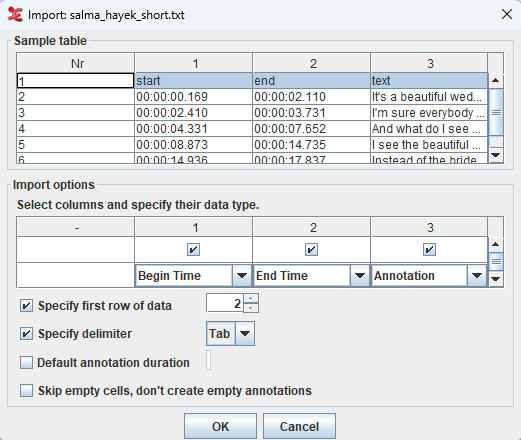

#### Praat
Open the textgrid file in the output/textgrid folder.


### <font color="orange">Exercise 2: Change the model size</font>
Change the model_size in the code above to "large-v3" and run the Whisper model again. After running the model, answer the following questions:

- Is the transcript more accurate compared to the based model?
- Did the duration of each segment change? Which one is more accurate?
- How long did it take for the large-v3 model to process a 37 seconds video?
- Did audience's voice affect the transcription accuracy?

*Make sure to add "_base" to the filename in the output folder. This is because whisper model won't run if there's a csv file with the same filename as the input wav file.